## The Mountain Car Environment and Open AI Gym

In this reinforcement learning notebook, the deep Q network that will be created will be trained on the Mountain Car environment/game. This can be accessed through the open source reinforcement learning library called Open AI Gym.

The object of this game is to get the car to go up the right-side hill to get to the flag. There’s one problem however, the car doesn’t have enough power to motor all the way up the hill. Instead, the car / agent needs to learn that it must motor up one hill for a bit, then accelerate down the hill and back up the other side, and repeat until it builds up enough momentum to make it to the top of the hill.

In [0]:
import gym
import tensorflow as tf
import random 
import numpy as np
import math
import matplotlib.pyplot as plt 

In [0]:
class GameRunner:
  def __init__(self, sess, model, env, memory, max_eps, min_eps,
                 decay, render=True):
        self._sess  = sess
        self._env   = env
        self._model = model
        self._memory  = memory
        self._render  = render
        self._max_eps = max_eps
        self._min_eps = min_eps
        self._decay   = decay
        self._eps   = self._max_eps
        self._steps = 0
        self._reward_store = []
        self._max_x_store  = []
        
  def run(self):
      state = self._env.reset()
      tot_reward = 0
      max_x = -100

      while True:
        #if self._render:      
          #self._env.render()
          
        action = self._choose_action(state)        
        next_state, reward, done, info = self._env.step(action)
        
        if next_state[0] >= 0.1:
          reward += 10
        elif next_state[0] >= 0.25:
          reward += 20
        elif next_state[0] >= 0.5:
          reward += 100

        if next_state[0] > max_x:
          max_x = next_state[0]
        # is the game complete? If so, set the next state to
        # None for storage sake
        if done:
          next_state = None

        self._memory.add_sample((state, action, reward, next_state))
        self._replay()

        # exponentially decay the eps value
        self._steps += 1
        self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) \
                                * math.exp(-LAMBDA * self._steps)

        # move the agent to the next state and accumulate the reward
        state = next_state
        tot_reward += reward

        # if the game is done, break the loop
        if done:
          self._reward_store.append(tot_reward)
          self._max_x_store.append(max_x)
          break
        
      print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))

  def _choose_action(self, state):
    if random.random() < self._eps:
        return random.randint(0, self._model._num_actions - 1)
    else:
        return np.argmax(self._model.predict_one(state, self._sess))
      
  def _replay(self):
    GAMMA=0.99 #added
    batch = self._memory.sample(self._model._batch_size)
    states = np.array([val[0] for val in batch])
    next_states = np.array([(np.zeros(self._model._num_states)
                             if val[3] is None else val[3]) for val in batch])
    # predict Q(s,a) given the batch of states
    q_s_a = self._model.predict_batch(states, self._sess)
    # predict Q(s',a') - so that we can do gamma * max(Q(s'a')) below
    q_s_a_d = self._model.predict_batch(next_states, self._sess)
    # setup training arrays
    x = np.zeros((len(batch), self._model._num_states))
    y = np.zeros((len(batch), self._model._num_actions))
    for i, b in enumerate(batch):
        state, action, reward, next_state = b[0], b[1], b[2], b[3]
        # get the current q values for all actions in state
        current_q = q_s_a[i]
        # update the q value for action
        if next_state is None:
            # in this case, the game completed after action, so there is no max Q(s',a')
            # prediction possible
            current_q[action] = reward
        else:
            current_q[action] = reward + GAMMA * np.amax(q_s_a_d[i])
        x[i] = state
        y[i] = current_q
    self._model.train_batch(self._sess, x, y)

In [0]:
class Model:
    def __init__(self, num_states, num_actions, batch_size):
        self._num_states = num_states
        self._num_actions = num_actions
        self._batch_size = batch_size
        # define the placeholders
        self._states = None
        self._actions = None
        # the output operations
        self._logits = None
        self._optimizer = None
        self._var_init = None
        # now setup the model
        self._define_model()

    def _define_model(self):
        self._states = tf.placeholder(shape=[None, self._num_states], dtype=tf.float32)
        self._q_s_a = tf.placeholder(shape=[None, self._num_actions], dtype=tf.float32)
        # create a couple of fully connected hidden layers
        fc1 = tf.layers.dense(self._states, 50, activation=tf.nn.relu)
        fc2 = tf.layers.dense(fc1, 50, activation=tf.nn.relu)
        self._logits = tf.layers.dense(fc2, self._num_actions)
        loss = tf.losses.mean_squared_error(self._q_s_a, self._logits)
        self._optimizer = tf.train.AdamOptimizer().minimize(loss)
        self._var_init = tf.global_variables_initializer()
        
    def predict_one(self, state, sess):
      return sess.run(self._logits, feed_dict={self._states:
                                               state.reshape(1, self._num_states)})

    def predict_batch(self, states, sess):
      return sess.run(self._logits, feed_dict={self._states: states})

    def train_batch(self, sess, x_batch, y_batch):
      sess.run(self._optimizer, feed_dict={self._states: x_batch, self._q_s_a: y_batch})

In [0]:
class Memory:
  def __init__(self, max_memory):
    self._max_memory = max_memory
    self._samples = []

  def add_sample(self, sample):
    self._samples.append(sample)
    if len(self._samples) > self._max_memory:
      self._samples.pop(0)

  def sample(self, no_samples):
    if no_samples > len(self._samples):
      return random.sample(self._samples, len(self._samples))
    else:
      return random.sample(self._samples, no_samples)    

In [0]:
# sets up the environment and run multiple games to perform the learning
env_name = 'MountainCar-v0'
env = gym.make(env_name)

In [0]:
# number of state and action
num_states  = env.env.observation_space.shape[0]
num_actions = env.env.action_space.n

Episode 1 of 300
Step 200, Total reward: -200.0, Eps: 0.1
Step 400, Total reward: -200.0, Eps: 0.1
Step 600, Total reward: -200.0, Eps: 0.1
Step 800, Total reward: -200.0, Eps: 0.1
Step 1000, Total reward: -200.0, Eps: 0.1
Step 1200, Total reward: -200.0, Eps: 0.1
Step 1400, Total reward: -200.0, Eps: 0.1
Step 1600, Total reward: -200.0, Eps: 0.1
Step 1800, Total reward: -200.0, Eps: 0.1
Step 2000, Total reward: -200.0, Eps: 0.1
Episode 11 of 300
Step 2200, Total reward: -200.0, Eps: 0.1
Step 2400, Total reward: -200.0, Eps: 0.1
Step 2600, Total reward: -200.0, Eps: 0.1
Step 2800, Total reward: -200.0, Eps: 0.1
Step 3000, Total reward: -200.0, Eps: 0.1
Step 3200, Total reward: -200.0, Eps: 0.1
Step 3400, Total reward: -200.0, Eps: 0.1
Step 3600, Total reward: -200.0, Eps: 0.1
Step 3800, Total reward: -200.0, Eps: 0.1
Step 4000, Total reward: -200.0, Eps: 0.1
Episode 21 of 300
Step 4200, Total reward: -200.0, Eps: 0.1
Step 4400, Total reward: -200.0, Eps: 0.1
Step 4600, Total reward: -2

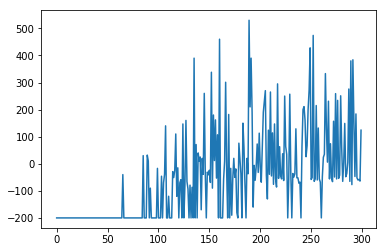

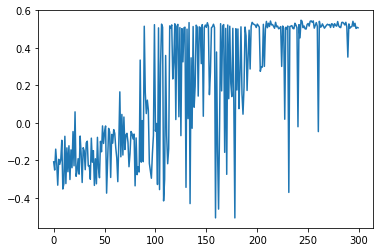

In [15]:
# build RL model
BATCH_SIZE=50
MAX_EPSILON=0.9
MIN_EPSILON=0.1
LAMBDA=0.2

model = Model(num_states, num_actions, BATCH_SIZE)
mem = Memory(50000)

with tf.Session() as sess:
  sess.run(model._var_init)
  gr = GameRunner(sess, model, env, mem, 
                  MAX_EPSILON, MIN_EPSILON, LAMBDA)
  num_episodes = 300
  cnt = 0
  while cnt < num_episodes:
    if cnt % 10 == 0:
      print('Episode {} of {}'.format(cnt+1, num_episodes))
    gr.run()
    cnt += 1
  plt.plot(gr._reward_store)
  plt.show()
  plt.close("all")
  plt.plot(gr._max_x_store)
  plt.show()